<a href="https://colab.research.google.com/github/radturkin/ChicagoElectionResults2024/blob/main/datacleaningandmap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import plotly.express as px

load data

In [2]:
precincts_geojson_path = 'https://data.cityofchicago.org/resource/6piy-vbxa.geojson?$limit=1500'

# Load the GeoJSON file into a GeoDataFrame
chicago_precincts = gpd.read_file(precincts_geojson_path)


# Load November 2024 presidential ("race 41"), all wards, all precincts
# chicago_results_path = 'https://drive.google.com/file/d/10FyUnrbZlCQ2fZA_dAyRJ2AIUHe6ANv0/view?usp=drive_link'
chicago_results_path = 'https://drive.google.com/uc?export=download&id=10FyUnrbZlCQ2fZA_dAyRJ2AIUHe6ANv0'  # Example

df = pd.read_csv(chicago_results_path, sep=",")

begin cleaning

In [3]:
ward_lines=[]
for index, line in df.iterrows():
  if str(line['Total Votes'])=='nan':
    ward_lines.append(int(index)+1)
#combine into single function later
ward=1
for index, line in df.iterrows():
  df.loc[index, 'Ward'] = ward # Assign the ward value directly to the DataFrame
  if int(index) in ward_lines:
    ward = line['Total Votes']


<ipython-input-3-23a4b14ac4a7>:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Ward 1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[index, 'Ward'] = ward # Assign the ward value directly to the DataFrame


resetting column names and dropping first few non data rows

In [4]:
df.columns = df.iloc[3]
# Drop the first row (which is now the header)
df = df[4:]

# Reset the index
df.reset_index(drop=True, inplace=True)

a little more cleaning

In [5]:
df.dropna(inplace=True)
clean_df=df.drop(df[df['Precinct'] == "Precinct"].index)
clean_df=clean_df.drop(clean_df[clean_df['Precinct'] == "Total"].index) #combine lines later for simplicity
clean_df.reset_index(drop=True, inplace=True)

clean_df.shape

(1291, 9)

merging dataframes

In [7]:
#merge data
df_merged = pd.concat([clean_df, chicago_precincts], axis=1)
df_merged.reset_index(drop=True, inplace=True)
df_merged = gpd.GeoDataFrame(df_merged)


Changing some column names for easier readability

In [9]:
df_merged.columns = ['Precinct', 'Total Voters', 'Kamala Harris', 'Kamala %',
       'Donald Trump', 'Trump %',
       'RFK', 'RFK%', 'Ward', 'shape_area',
       'ward_precinct', 'shape_leng', 'precinct', 'ward', 'geometry']

,Precinct,Total Voters,Kamala Harris,Kamala %,Donald Trump,Trump %,RFK,RFK%,Ward,shape_area,ward_precinct,shape_leng,precinct,ward,geometry
0,1,937,830,88.58%,95,10.14%,12,1.28%,Ward 1,0.000025518459758,01001,0.0245635601862,1.0,1.0,"MULTIPOLYGON (((-87.70494 41.92756, -87.70522 ..."
1,2,961,857,89.18%,96,9.99%,8,0.83%,Ward 1,0.0000354799012622,01002,0.0328451023812,2.0,1.0,"MULTIPOLYGON (((-87.69743 41.92531, -87.69752 ..."
2,3,941,835,88.74%,94,9.99%,12,1.28%,Ward 1,0.0000444142531941,01003,0.0353006733058,3.0,1.0,"MULTIPOLYGON (((-87.69625 41.92664, -87.69627 ..."
3,4,1027,937,91.24%,84,8.18%,6,0.58%,Ward 1,0.0000283054023451,01004,0.0232314930038,4.0,1.0,"MULTIPOLYGON (((-87.7016 41.92061, -87.70164 4..."
4,5,998,891,89.28%,95,9.52%,12,1.20%,Ward 1,0.0000287044306217,01005,0.024817970029,5.0,1.0,"MULTIPOLYGON (((-87.69722 41.91814, -87.69722 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,24,918,212,23.09%,702,76.47%,4,0.44%,Ward 50,0.0000638846280744,50024,0.0359983912263,24.0,50.0,"MULTIPOLYGON (((-87.72137 41.99066, -87.72189 ..."
1287,25,193,112,58.03%,79,40.93%,2,1.04%,Ward 50,0.0000239899162322,50025,0.0210184875086,25.0,50.0,"MULTIPOLYGON (((-87.714 41.99076, -87.71403 41..."
1288,26,380,177,46.58%,200,52.63%,3,0.79%,Ward 50,0.0000213589720788,50026,0.0190952104225,26.0,50.0,"MULTIPOLYGON (((-87.71066 41.99737, -87.71052 ..."
1289,27,177,90,50.85%,84,47.46%,3,1.69%,Ward 50,0.00000360082423835,50027,0.00770295682847,27.0,50.0,"MULTIPOLYGON (((-87.70928 42.00706, -87.70926 ..."


Converting Kamala % column from obj to float

In [12]:
# Convert 'Kamala%' column to float, handling errors
df_merged['Kamala'] = df_merged['Kamala %'].apply(lambda x: float(x.rstrip('%')))

Map the data!

In [22]:
#simplify to decrease run time (loses some accuracy by 10m)
df_merged["geometry"] = (
    df_merged.to_crs(df_merged.estimate_utm_crs()).simplify(10).to_crs(df_merged.crs)
)
# Assuming ward_50_precincts is already defined as in the previous code

# Create the choropleth map
fig = px.choropleth_mapbox(df_merged,
                           geojson=df_merged.geometry,
                           locations=df_merged.index,
                           color='Kamala', # Or another column for color differentiation
                           mapbox_style="carto-positron",
                           zoom=10,
                           center={"lat": 41.8781, "lon": -87.6298}, # Chicago's coordinates
                           opacity=0.5,
                           hover_name = "ward_precinct",  # Or other column for hover info
                          #  hover_data= ["Trump%", "Kamala%"]
                           hover_data = {'Kamala %':True,'Trump %':True,'Kamala':False},
                            color_continuous_scale='RdBu'  # Use the red-to-blue color scale
                          )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Output cleaned and merged data to csv

In [21]:
df_merged.to_csv('merged_chicago_elections_1.csv', index=False)


Map using geopandas, just because

<Axes: >

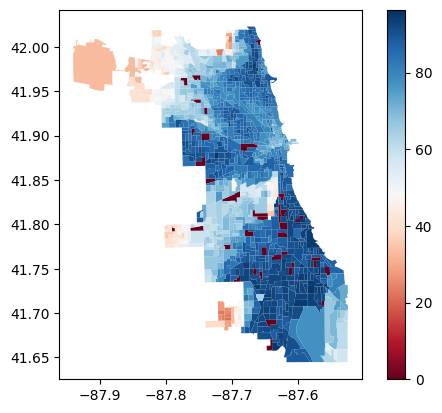

In [27]:
df_merged.plot(column='Kamala', legend=True , cmap='RdBu')

In [ ]:
df_merged.head()

Parsing alternative, courtesy of Hugh

In [ ]:
# Load November 2024 presidential results, all wards, all precincts from Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
election_results_path = '/content/drive/My Drive/West Ridge/ChicagoElectionsResults.csv'
with open(election_results_path, 'r') as f:
    text = f.read()

# takes the text content of a Chicago Board of Elections city-wide result csv
# returns a list of precincts with select results
def parseElectionResults(text):
  ward = 0
  wards = []
  for line in text.splitlines():
      if line:
        tokens = line.split(',') # csv field sep is comma
        if tokens:
          if tokens[0]:
            if tokens[0] == 'Precinct':
              continue
            if tokens[0] == 'Totals':
              continue
            if tokens[0].startswith('Ward '):
              ward = int(tokens[0].split(' ')[1])
              continue
            if tokens[0].isdigit():
              precinct = int(tokens[0])
              ward_precinct = "{:02d}".format(ward) + "{:03d}".format(precinct) # index for merge with City geojson
              total = int(tokens[1]) # total votes cast, including also-rans
              dem = int(tokens[2]) # Harris-Walz
              gop = int(tokens[4]) # Trump-Vance
              wards.append({'ward_precinct': ward_precinct, 'ward': ward, 'precinct': precinct,  'total': total, 'dem': dem, 'gop': gop})
  return wards

wards = parseElectionResults(text)
wards

